## Import required libraries

In [198]:
import warnings
warnings.filterwarnings('ignore')

In [199]:
from surprise.model_selection import RandomizedSearchCV , GridSearchCV , KFold 
from surprise import BaselineOnly, KNNBaseline, SVD, SVDpp
from surprise import Reader, Dataset
import xgboost as xgb
import pandas as pd 
import numpy as np
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV as GridSearch, RandomizedSearchCV as RandomSearch, KFold as KF
from collections import OrderedDict

### NOTE: 
#### Must have to use aliasing for sklearn GridSearchCV, RandomizedSearchCV and KFold because we are using same method from surprise library also.

## Reading Train and Test data to dataframe :

#### 1.Train_dataframe

In [223]:
train_reg = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                  'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 
                                                  'UAvg', 'MAvg', 'rating'], header=None)
train_reg.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,174683,10,3.587581,5.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5
1,233949,10,3.587581,4.0,4.0,5.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,2.692308,3.611111,3
2,555770,10,3.587581,4.0,5.0,4.0,4.0,5.0,4.0,2.0,5.0,4.0,4.0,3.795455,3.611111,4
3,767518,10,3.587581,2.0,5.0,4.0,4.0,3.0,5.0,5.0,4.0,4.0,3.0,3.884615,3.611111,5
4,894393,10,3.587581,3.0,5.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.000000,3.611111,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

#### 2.Test_dataframe 

In [224]:
test_reg = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
test_reg.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,5
1,941866,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4
2,1737912,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3
3,1849204,71,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,3.587581,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

## Transforming data for Surprise models

#### 1.Transforming train data

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [225]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(train_reg[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

#### 2.Transforming test data

- Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant) 

In [226]:
testset = list(zip(test_reg.user.values, test_reg.movie.values, test_reg.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

## Applying Machine Learning models

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [227]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

### Function to print parameters summary:

In [205]:
def param_list(params, para_summ):
    para_summ.clear_rows()
    for name, val in zip(params.keys(),params.values()):
        para_summ.add_row([name, val])
    print(para_summ)

### Function for feature importance:

In [206]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### Function required for Surprise Models:
### SURPRISE:

#### 1. Function for Hyperparameter Tunning :

In [207]:
def hyperparamTUNNING(clf, data, params, CV, name, searchMethod='random'):
    if searchMethod=='random':
        model=RandomizedSearchCV(clf,\
                                 param_distributions=params,\
                                 n_iter=20,\
                                 n_jobs=16,\
                                 measures=['rmse', 'mae'],\
                                 return_train_measures=True)
    elif searchMethod=='grid':
        model=GridSearchCV(clf,\
                           param_grid=params,\
                           n_jobs=-1,\
                           measures=['rmse','mae'],\
                           cv=CV,\
                           return_train_measures=True)
    model.fit(data)
    tr_rmse = model.cv_results['mean_train_rmse']
    cv_rmse = model.cv_results['mean_test_rmse']
    for i in range(len(tr_rmse)):
        print('Train RMSE: %.4f'%tr_rmse[i],'CV RMSE: %.4f'%cv_rmse[i])
    # BEST RMSE AND COMBINATION OF OPTIMAL PARAMETERS VALUES TO GET THAT RMSE
    print('\n\nBest RMSE: %.5f'%model.best_score['rmse'],'For Optimal Params Combination Value:')
    if name=='knn':
        print('\t[1.]K: %d'%model.best_params['rmse']['k'],\
              '\n\t[2.]shrinkage: %d'%model.best_params['rmse']['sim_options']['shrinkage'],\
              '\n\t[3.]lerning_rate: %.4f'%model.best_params['rmse']['bsl_options']['learning_rate'],\
              '\n\t[4.]Epochs: %d'%model.best_params['rmse']['bsl_options']['n_epochs'])
    elif name=='bsl':
        #print(model.best_params)
        print('\t[1.]Learning-Rate: %.4f'%model.best_params['rmse']['bsl_options']['learning_rate'],\
              '\n\t[2.]Epochs: %d'%model.best_params['rmse']['bsl_options']['n_epochs'])
    elif name=='svd':
        print('\t[1.]N-Factors: %d'%model.best_params['rmse']['n_factors'],\
              '\n\t[2.]Epochs: %d'%model.best_params['rmse']['n_epochs'],\
              '\n\t[3.]Learning-Rate: %.4f'%model.best_params['rmse']['lr_all'],\
              '\n\t[4.]Reg-All: %.4f'%model.best_params['rmse']['reg_all'])
    return model

#### 2. function for measure rating:

In [208]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted
#in surprise prediction of every data point is returned as dictionary like this:
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating 

#### 3. function for error measurement:

In [209]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

#### 4. function for measure performance on test data: 

In [210]:
my_seed = 15
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name, model_summ_local, model_summary=None):
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
    train_pred = algo.test(trainset.build_testset())
   
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    #print("TRAIN RMSE(WITH OPTIMAL VALUE OF PARAMS) = %.6f"%train_rmse)
    #print("TRAIN MAPE(WITH OPTIMAL VALUE OF PARAMS) = %.6f"%train_mape)
    #print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    #print("TEST DATA")
    #PREDICTIONS ON TEST DATA
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    #print("TEST RMSE(WITH OPTIMAL VALUE OF PARAMS) = %.6f"%test_rmse)
    #print("TEST MAPE(WITH OPTIMAL VALUE OF PARAMS) = %.6f"%test_mape)
    #print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "prediction": test_predicted}
    
    #PRINT PERFORMANCE WITH BEST PARAMS
    model_summ_local.add_row([model_name, '%.5f'%train_rmse, '%.5f'%train_mape, '%.5f'%test_rmse, '%.5f'%test_mape])
    print('Performance Summary (WITH OPTIMAL VALUE OF PARAMETERS):')
    
    if model_summary !=None:
        model_summary.add_row([model_name, '%.5f'%train_rmse, '%.5f'%train_mape, '%.5f'%test_rmse, '%.5f'%test_mape])
    #make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test, model_summ_local

In [211]:
def testPerformance(clf, trainset, testset, train_reg, test_reg, model_name, model_summary=None, add_to_xgboost=False):
    model_summ_local=PrettyTable()
    model_summ_local.field_names=['Model', 'Train(RMSE)', 'Train(MAPE)', 'Test(RMSE)', 'Test(MAPE)']
    #APPLYING MODEL WITH OPTIMAL VALUE OF HYPEPARAMS
    train_result, test_result, model_summ_local = run_surprise(clf, trainset, testset, model_name, model_summ_local, model_summary)
    #ADD PRDICTED DATA AS NEW COLUMN FROM SURPISE MODEL TO XGBOOST DATA = XGBOOST_FEATS + SURPRISE_O/P
    if add_to_xgboost:
        train_reg[model_name]=train_result['prediction']
        test_reg[model_name]=test_result['prediction']
    return train_result, test_result, model_summ_local

# ===============================================================

### Functions required for XGBOOST models :
### XGBOOST (GBDT)

#### 1. function for scorer for Grid search and Random search:

In [212]:
def cust_scorer(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    #mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse

#### 2. function for Tunning hypeparam:

In [213]:
def Ensemble_Regressor(x_train,y_train,CV,params_, tune_param, searchMethod):
    #INITIALIZE GBDT CLASSIFIER
    reg=xgb.XGBRegressor(n_estimators=params_['n_estimators'],\
                          max_depth=params_['max_depth'],\
                          eta=.02,\
                          reg_alpha=params_['reg_alpha'],\
                          min_child_weight=params_['min_child_weight'],\
                          gamma=params_['gamma'],\
                          subsample=params_['subsample'],\
                          colsample_bytree=params_['colsample_bytree'],\
                          booster='gbtree')
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='random':
        model=RandomSearch(reg,\
                           n_jobs=-1,\
                           cv=CV,\
                           param_distributions=tune_param,\
                           n_iter=3,\
                           return_train_score=True,\
                           scoring=make_scorer(cust_scorer, greater_is_better=False))
    elif searchMethod=='grid':
        model= GridSearch(estimator=reg,\
                          param_grid=tune_param,\
                          scoring=make_scorer(cust_scorer, greater_is_better=False),\
                          n_jobs=-1,\
                          cv=CV,\
                          return_train_score=True
                         )
    model.fit(x_train,y_train)
    #PLOT THE PERFORMANCE OF MODEL ON CROSSVALIDATION DATA FOR EACH HYPERPARAM VALUE
    train_rmse = model.cv_results_['mean_train_score']
    cv_rmse = model.cv_results_['mean_test_score']
    #if len(param_name.split())==1:
    for i in range(len(train_rmse)):
        print('Train RMSE: %.4f'%abs(train_rmse[i]),'CV RMSE: %.4f'%abs(cv_rmse[i]))
    print()
    return model

In [214]:
def tuneALL_PARAM_XGB(train, y_train, CV, params_range, params_, searchMethod):
    for param_name, param_list in zip(params_range.keys(),params_range.values()):
        tune_param={}
        tune_param[param_name]=param_list
        #TUNNING HYPERPARAM
        print('Tunning {}:'.format(param_name.upper()))
        model=Ensemble_Regressor(train, y_train, CV, params_, tune_param, searchMethod)
        #UPDATE OTIMAL VALUE OF PARAMETER
        params_[param_name] = model.best_params_[param_name]
    return model, params_

#### 3. function for measuring perfromance on test data:

In [215]:
def test_performance_xgb(x_train,y_train,x_test,y_test,params_, model_summary,model_use=None,summary=False):
    '''FUNCTION FOR TEST PERFORMANCE(PLOT ROC CURVE FOR BOTH TRAIN AND TEST) WITH OPTIMAL HYPERPARAM'''
    train_result={}
    test_result={}
    #INITIALIZE GBDT WITH OPTIMAL VALUE OF HYPERPARAMS
    clf=xgb.XGBRegressor(n_estimators=params_['n_estimators'],\
                          max_depth=params_['max_depth'],\
                          eta=.02,\
                          reg_alpha=params_['reg_alpha'],\
                          min_child_weight=params_['min_child_weight'],\
                          gamma=params_['gamma'],\
                          subsample=params_['subsample'],\
                          colsample_bytree=params_['colsample_bytree'],\
                          booster='gbtree',\
                         verbose=1)
   
    clf.fit(x_train, y_train)
    #PREDICTION FOR TRAIN AND TEST
    y_pred=clf.predict(x_test)
    y_pred_tr=clf.predict(x_train)
    
    #TEST RMSE AND MAPE
    test_rmse=abs(np.sqrt(mean_squared_error(y_test, y_pred)))
    test_mape=np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    #TRAIN RMSE AND MAPE
    train_rmse=abs(np.sqrt(mean_squared_error(y_train, y_pred_tr)))
    train_mape=np.mean(np.abs((y_train - y_pred_tr) / y_train)) * 100
    
    #SAVE RESULT GLOBALLY
    train_result['RMSE']=train_rmse; train_result['MAPE']=train_mape; train_result['prediction']=y_pred_tr
    test_result['RMSE']=test_rmse; test_result['MAPE']=test_mape; test_result['prediction']=y_pred
    
    print('FOR OPTIMAL PARAMETERS, TRAIN RMSE: %.5f,  TEST RMSE: %.5f'%(train_rmse, test_rmse))
    model_summ_local=PrettyTable()
    model_summ_local.field_names=['Model', 'Train(RMSE)', 'Train(MAPE)', 'Test(RMSE)', 'Test(MAPE)']
    model_summ_local.add_row([model_use, '%.5f'%train_rmse, '%.5f'%train_mape, '%.5f'%test_rmse, '%.5f'%test_mape])
    plot_importance(xgb, clf)
    #print(model_local_summ)
    if summary:
        model_summary.add_row([model_use, '%.5f'%train_rmse, '%.5f'%train_mape,'%.5f'%test_rmse, '%.5f'%test_mape])
    return train_result, test_result, model_summ_local

# ============================================================

# MODELS:

### Initialization of common objects for Baseline and Matrix Factorization models:

In [228]:
#DATA
data = Dataset.load_from_df(train_reg[['user', 'movie', 'rating']], reader)

#TUNNING ALGORITH TO BE USED
searchMethod=['random', 'grid']

#HYPERPARAM RANGE
min_k=[1]
k=[20,30,40,60]
bsl_options = {'method' : ['sgd'], 'learning_rate':[.001,.01,.05,.1], 'n_epochs':[10,20]}
sim_options= {'name': ['pearson_baseline'] , 'user_based': [True], 'shrinkage':[80,100,120,140]}

#DICT OF HYPERPARAM
params={ }

#DICT HYPERPARAMS FOR SVD AND SVDPP 
params_svd=OrderedDict([('n_factors',[10,30,50,70,90]),\
                        ('n_epochs',[10,20,30,40]),\
                        ('lr_all',[.003,.005,.008,.1]),\
                        ('reg_all',[0.0,.02,.05,.07,.09])])
#MODEL USED
model_name=['XGBOOST-13-FEATS', 'BaselineOnly', 'XGBOOST-BSL', 'KNNBaseline-U-U',\
            'KNNBaseline-I-I', 'XGBOOST-KNN', 'SVD', 'SVD++', 'XGBOOST-13-BSL-KNN-MF', 'XGBOOST-BSL-KNN-MF', ]


#GLOBAL SUMMARY OF ALL THE MODELS
model_summary=PrettyTable()
model_summary.field_names=['Model', 'Train(RMSE)', 'Train(MAPE)', 'Test(RMSE)', 'Test(MAPE)']

#CROSS VALIDATION SPLIT OBJECT
CV_= KFold(n_splits=5)

### Initialization of common objects for XGBOOST model:

In [229]:
#DICT OF PARAMETERS, INITIALLY SET RESONABLE VALUES FOR PARAMETER, AND AFTER TUNNING UPDATE VALUE WITH OPT. VALUE
params_=OrderedDict([
    ('n_estimators',64),
    ('max_depth',5),
    ('min_child_weight',1),
    ('gamma',0),
    ('subsample',.8),
    ('colsample_bytree',.8),
    ('reg_alpha',.1)]
)


# DICT OF HYPERPARAMETER FOR XGBOOST WITH RANGE OF VALUES
params_range=OrderedDict([('n_estimators', [32,64,80,100]),\
         ('max_depth', [5,7,9]),\
         ('min_child_weight', [1,3,5]),\
         ('gamma', [i/10.0 for i in range(0,5)]),\
         ('subsample', [.6,.7,.8,.9]),\
         ('colsample_bytree', [.6,.7,.8,.9]),\
         ('reg_alpha',[0, 0.001, 0.005, 0.01, 0.05])])

#CV SPLIT (HERE KF STANDS/ALIAS FOR KFold() method of sklearn) 
CV = KF(n_splits=5)

#SEARCHING ALGO FOR HYPERPARAM
searchMethod=['random', 'grid']

#
param_summ=PrettyTable()
param_summ.field_names=['Parameter', 'Value']

## 1. XGBOOST-13:

#### [1.1]Hyperparameter Tunnning: 

In [230]:
%%time
#TRAIN AND TEST DATA FOR XGBOOST MODELS
train, test = train_reg.drop(["user", "movie", "rating"], axis = 1), test_reg.drop(["user", "movie", "rating"], axis = 1)
y_train, y_test = train_reg["rating"], test_reg["rating"]
print('HYPERPARAMETER:\n')
param_list(params_range, param_summ)
print()
model, params_ = tuneALL_PARAM_XGB(train, y_train, CV, params_range, params_, searchMethod[1])

HYPERPARAMETER:

+------------------+-------------------------------+
|    Parameter     |             Value             |
+------------------+-------------------------------+
|   n_estimators   |       [32, 64, 80, 100]       |
|    max_depth     |           [5, 7, 9]           |
| min_child_weight |           [1, 3, 5]           |
|      gamma       |   [0.0, 0.1, 0.2, 0.3, 0.4]   |
|    subsample     |      [0.6, 0.7, 0.8, 0.9]     |
| colsample_bytree |      [0.6, 0.7, 0.8, 0.9]     |
|    reg_alpha     | [0, 0.001, 0.005, 0.01, 0.05] |
+------------------+-------------------------------+

Tunning N_ESTIMATORS:
Train RMSE: 0.8421 CV RMSE: 0.8624
Train RMSE: 0.8235 CV RMSE: 0.8507
Train RMSE: 0.8197 CV RMSE: 0.8507
Train RMSE: 0.8157 CV RMSE: 0.8511

Tunning MAX_DEPTH:
Train RMSE: 0.8197 CV RMSE: 0.8507
Train RMSE: 0.7778 CV RMSE: 0.8551
Train RMSE: 0.7043 CV RMSE: 0.8640

Tunning MIN_CHILD_WEIGHT:
Train RMSE: 0.8197 CV RMSE: 0.8507
Train RMSE: 0.8200 CV RMSE: 0.8505
Train RMSE: 0.8

#### [1.2]Optimal value of parameters after tunning:

In [231]:
print('Optimal Value of Hyperparameters after Tunning:\n')
param_list(params_,param_summ)


Optimal Value of Hyperparameters after Tunning:

+------------------+-------+
|    Parameter     | Value |
+------------------+-------+
|   n_estimators   |   80  |
|    max_depth     |   5   |
| min_child_weight |   5   |
|      gamma       |  0.3  |
|    subsample     |  0.8  |
| colsample_bytree |  0.6  |
|    reg_alpha     |  0.05 |
+------------------+-------+


#### [1.3]Test performance :

FOR OPTIMAL PARAMETERS, TRAIN RMSE: 0.82606,  TEST RMSE: 1.07701


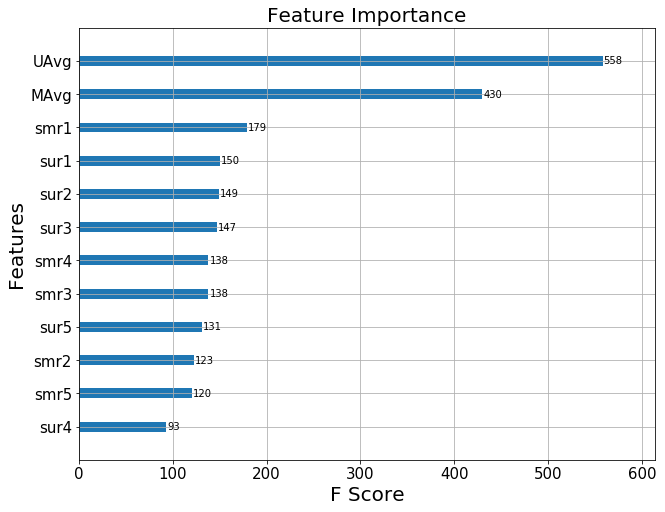

CPU times: user 4.62 s, sys: 1.86 s, total: 6.48 s
Wall time: 3.83 s


In [232]:
%%time
train_result, test_result, model_summ_local=test_performance_xgb(train, y_train, test, y_test,\
                                                                 params_, model_summary, model_name[0], summary=True)

#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[0]] = train_result
models_evaluation_test[model_name[0]] = test_result

#### [1.4] Model Summary:

In [233]:
#MODEL SUMMARY
print(model_summ_local)

+------------------+-------------+-------------+------------+------------+
|      Model       | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+------------------+-------------+-------------+------------+------------+
| XGBOOST-13-FEATS |   0.82606   |   24.16566  |  1.07701   |  33.59137  |
+------------------+-------------+-------------+------------+------------+


# =============================================================

## 2. BaselineOnly:
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases)

Optimization function:

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

#### [a.] Hyperparam Tunning:

In [234]:
%%time
#MODEL USED
clf = BaselineOnly

#DICTIONARY OF HYPERPARAM TO BE TUNED 
params['bsl_options']=bsl_options

print('HYPERPARAMETER:\n')
param_list(params, param_summ)

#HYPERPARAM TUNNING
model = hyperparamTUNNING(clf, data, params, CV_, 'bsl', searchMethod[1])

HYPERPARAMETER:

+-------------+--------------------------------------------------------------------------------------+
|  Parameter  |                                        Value                                         |
+-------------+--------------------------------------------------------------------------------------+
| bsl_options | {'method': ['sgd'], 'n_epochs': [10, 20], 'learning_rate': [0.001, 0.01, 0.05, 0.1]} |
+-------------+--------------------------------------------------------------------------------------+
Train RMSE: 0.9780 CV RMSE: 0.9899
Train RMSE: 0.8758 CV RMSE: 0.9525
Train RMSE: 0.7894 CV RMSE: 0.9767
Train RMSE: 0.7777 CV RMSE: 1.0077
Train RMSE: 0.9564 CV RMSE: 0.9779
Train RMSE: 0.8309 CV RMSE: 0.9510
Train RMSE: 0.7647 CV RMSE: 0.9968
Train RMSE: 0.7687 CV RMSE: 1.0247


Best RMSE: 0.95096 For Optimal Params Combination Value:
	[1.]Learning-Rate: 0.0100 
	[2.]Epochs: 20
CPU times: user 44.4 s, sys: 84 ms, total: 44.5 s
Wall time: 45.2 s


#### [b.]Performance on test data and summary:

In [235]:
%%time
#INITIALIZE CLASSIFIER WITH BEST PARAMS VALUE
clf=BaselineOnly(bsl_options=model.best_params['rmse']['bsl_options'])
#MEASURE PERFORMANCE ON TEST DATA
train_result, test_result, model_summ_local=testPerformance(clf,trainset, testset, train_reg, test_reg,\
                                 model_name[1],model_summary, add_to_xgboost=True)
#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[1]] = train_result
models_evaluation_test[model_name[1]] = test_result

#PRINT PERFROMANCE SUMMARY 
print(model_summ_local)

Estimating biases using sgd...
Performance Summary (WITH OPTIMAL VALUE OF PARAMETERS):
+--------------+-------------+-------------+------------+------------+
|    Model     | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+--------------+-------------+-------------+------------+------------+
| BaselineOnly |   0.83552   |   25.25685  |  1.07429   |  35.12019  |
+--------------+-------------+-------------+------------+------------+
CPU times: user 828 ms, sys: 4 ms, total: 832 ms
Wall time: 830 ms


# ============================================================

## 3. XGBOOST(13 + BSL):

#### [3.1.] Hyperparameter Tunning:

In [236]:
%%time
#TRAIN AND TEST DATA FOR XGBOOST MODELS
train, test = train_reg.drop(["user", "movie", "rating"], axis = 1), test_reg.drop(["user", "movie", "rating"], axis = 1)
y_train, y_test = train_reg["rating"], test_reg["rating"]
print('HYPERPARAMETER:\n')
param_list(params_range, param_summ)
print()
model, params_ = tuneALL_PARAM_XGB(train, y_train, CV, params_range, params_, searchMethod[1])

HYPERPARAMETER:

+------------------+-------------------------------+
|    Parameter     |             Value             |
+------------------+-------------------------------+
|   n_estimators   |       [32, 64, 80, 100]       |
|    max_depth     |           [5, 7, 9]           |
| min_child_weight |           [1, 3, 5]           |
|      gamma       |   [0.0, 0.1, 0.2, 0.3, 0.4]   |
|    subsample     |      [0.6, 0.7, 0.8, 0.9]     |
| colsample_bytree |      [0.6, 0.7, 0.8, 0.9]     |
|    reg_alpha     | [0, 0.001, 0.005, 0.01, 0.05] |
+------------------+-------------------------------+

Tunning N_ESTIMATORS:
Train RMSE: 0.8435 CV RMSE: 0.8628
Train RMSE: 0.8255 CV RMSE: 0.8502
Train RMSE: 0.8220 CV RMSE: 0.8502
Train RMSE: 0.8179 CV RMSE: 0.8506

Tunning MAX_DEPTH:
Train RMSE: 0.8220 CV RMSE: 0.8502
Train RMSE: 0.7852 CV RMSE: 0.8533
Train RMSE: 0.7253 CV RMSE: 0.8579

Tunning MIN_CHILD_WEIGHT:
Train RMSE: 0.8216 CV RMSE: 0.8505
Train RMSE: 0.8217 CV RMSE: 0.8504
Train RMSE: 0.8

#### [3.2]Optimal value of parameters after tunning:

In [237]:
print('Optimal Value of Hyperparameters after Tunning:\n')
param_list(params_,param_summ)


Optimal Value of Hyperparameters after Tunning:

+------------------+-------+
|    Parameter     | Value |
+------------------+-------+
|   n_estimators   |   80  |
|    max_depth     |   5   |
| min_child_weight |   5   |
|      gamma       |  0.4  |
|    subsample     |  0.8  |
| colsample_bytree |  0.6  |
|    reg_alpha     |  0.05 |
+------------------+-------+


#### [3.3]Test performance :

FOR OPTIMAL PARAMETERS, TRAIN RMSE: 0.82509,  TEST RMSE: 1.06767


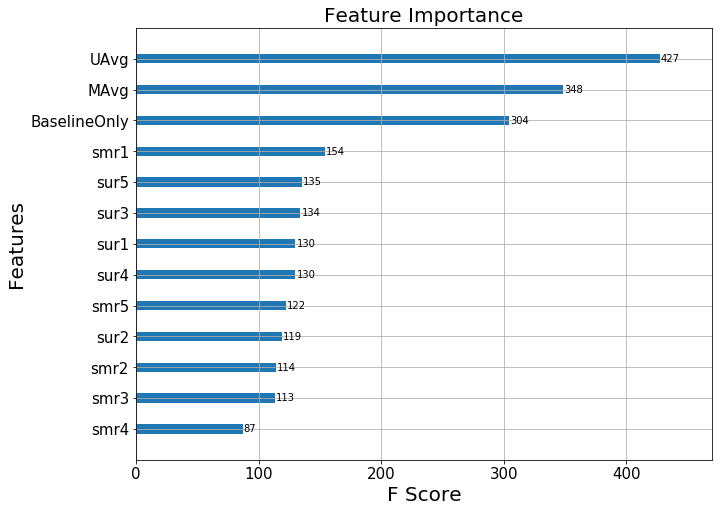

CPU times: user 4.33 s, sys: 300 ms, total: 4.63 s
Wall time: 4.18 s


In [238]:
%%time
train_result, test_result, model_local_summ=test_performance_xgb(train, y_train, test, y_test,\
                                                                 params_, model_summary, model_name[2], summary=True)

#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[2]] = train_result
models_evaluation_test[model_name[2]] = test_result

#### [3.4]Model Summary:

In [239]:
#MODEL SUMMARY
print(model_local_summ)

+-------------+-------------+-------------+------------+------------+
|    Model    | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+-------------+-------------+-------------+------------+------------+
| XGBOOST-BSL |   0.82509   |   24.14721  |  1.06767   |  34.57024  |
+-------------+-------------+-------------+------------+------------+


# ============================================================

### 4.KNNBaseline-U-U:
Based on User-User similarity
\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}
Based on Item-Item similarity
\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}
- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
Based on Item-Item similarity


#### [a.] Hyperparam Tunning:

In [240]:
%%time
#DICT HYPERPARAM 
params['k']=k
params['min_k']=min_k
params['sim_options']=sim_options
print('HYPERPARAMETER:\n')
param_list(params, param_summ)
print()
#HYPERPARAM TUNNING
clf=KNNBaseline
model = hyperparamTUNNING(clf, data, params, CV_, 'knn', searchMethod[0])

HYPERPARAMETER:

+-------------+----------------------------------------------------------------------------------------+
|  Parameter  |                                         Value                                          |
+-------------+----------------------------------------------------------------------------------------+
|      k      |                                    [20, 30, 40, 60]                                    |
| bsl_options |  {'method': ['sgd'], 'n_epochs': [10, 20], 'learning_rate': [0.001, 0.01, 0.05, 0.1]}  |
| sim_options | {'user_based': [True], 'shrinkage': [80, 100, 120, 140], 'name': ['pearson_baseline']} |
|    min_k    |                                          [1]                                           |
+-------------+----------------------------------------------------------------------------------------+

Train RMSE: 0.1190 CV RMSE: 0.9583
Train RMSE: 0.1356 CV RMSE: 0.9664
Train RMSE: 0.1151 CV RMSE: 0.9549
Train RMSE: 0.2085 CV RMSE: 0.9655
Tr

#### [b.]Performance on test data:

In [241]:
%%time
#INITIALIZE CLASSIFIER WITH BEST PARAMS VALUE
clf=KNNBaseline(k=model.best_params['rmse']['k'],\
           bsl_options=model.best_params['rmse']['bsl_options'],\
           sim_options=model.best_params['rmse']['sim_options'],\
           min_k=model.best_params['rmse']['min_k'])

#MEASURE PERFORMANCE ON TEST DATA
train_result, test_result, model_summ_local=testPerformance(clf, trainset, testset, train_reg, test_reg, model_name[3], \
                                                            model_summary=model_summary, add_to_xgboost=True)
#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[3]] = train_result
models_evaluation_test[model_name[3]] = test_result

#PRINT PERFROMANCE SUMMARY 
print(model_summ_local)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Performance Summary (WITH OPTIMAL VALUE OF PARAMETERS):
+-----------------+-------------+-------------+------------+------------+
|      Model      | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+-----------------+-------------+-------------+------------+------------+
| KNNBaseline-U-U |   0.14034   |   3.41399   |  1.07426   |  35.11784  |
+-----------------+-------------+-------------+------------+------------+
CPU times: user 2min, sys: 7.64 s, total: 2min 8s
Wall time: 2min 8s


# ============================================================

## 5.KNNBaseline-I-I:

#### [a.] Hyperparam Tunning:

In [242]:
%%time
#DICT OF HYPERPARAM
params['sim_options']['user_based'][0]=False
print('HYPERPARAMETER:\n')
param_list(params, param_summ)
print()
#HYPERPARAM TUNNING
clf=KNNBaseline
model = hyperparamTUNNING(clf, data, params, CV, 'knn', searchMethod[0])

HYPERPARAMETER:

+-------------+-----------------------------------------------------------------------------------------+
|  Parameter  |                                          Value                                          |
+-------------+-----------------------------------------------------------------------------------------+
|      k      |                                     [20, 30, 40, 60]                                    |
| bsl_options |   {'method': ['sgd'], 'n_epochs': [10, 20], 'learning_rate': [0.001, 0.01, 0.05, 0.1]}  |
| sim_options | {'user_based': [False], 'shrinkage': [80, 100, 120, 140], 'name': ['pearson_baseline']} |
|    min_k    |                                           [1]                                           |
+-------------+-----------------------------------------------------------------------------------------+

Train RMSE: 0.1022 CV RMSE: 1.0509
Train RMSE: 0.0856 CV RMSE: 1.0512
Train RMSE: 0.0498 CV RMSE: 1.0467
Train RMSE: 0.0955 CV RMSE: 1

#### [b.]Performance on test data and summary:

In [244]:
%%time
#INITIALIZE CLASSIFIER WITH BEST PARAMS VALUE
clf=KNNBaseline(k=model.best_params['rmse']['k'],\
           bsl_options=model.best_params['rmse']['bsl_options'],\
           sim_options=model.best_params['rmse']['sim_options'],\
           min_k=model.best_params['rmse']['min_k'])

#MEASURE PERFORMANCE ON TEST DATA
train_result, test_result, model_summ_local=testPerformance(clf, trainset, testset, train_reg, test_reg, model_name[4], \
                                                            model_summary=model_summary, add_to_xgboost=True)

#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[4]] = train_result
models_evaluation_test[model_name[4]] = test_result

#PRINT PERFROMANCE SUMMARY 
print(model_summ_local)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Performance Summary (WITH OPTIMAL VALUE OF PARAMETERS):
+-----------------+-------------+-------------+------------+------------+
|      Model      | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+-----------------+-------------+-------------+------------+------------+
| KNNBaseline-I-I |   0.27398   |   6.45966   |  1.07461   |  35.19819  |
+-----------------+-------------+-------------+------------+------------+
CPU times: user 2.29 s, sys: 8 ms, total: 2.3 s
Wall time: 2.3 s


# ============================================================

## 6.XGBOOST(13 + BSL + KNN)

#### [6.1.] Hyperparameter Tunning:

In [245]:
%%time
#TRAIN AND TEST DATA FOR XGBOOST MODELS
train, test = train_reg.drop(["user", "movie", "rating"], axis = 1), test_reg.drop(["user", "movie", "rating"], axis = 1)
y_train, y_test = train_reg["rating"], test_reg["rating"]
print('HYPERPARAMETER:\n')
param_list(params_range, param_summ)
print()
model, params_ = tuneALL_PARAM_XGB(train, y_train, CV, params_range, params_, searchMethod[1])

HYPERPARAMETER:

+------------------+-------------------------------+
|    Parameter     |             Value             |
+------------------+-------------------------------+
|   n_estimators   |       [32, 64, 80, 100]       |
|    max_depth     |           [5, 7, 9]           |
| min_child_weight |           [1, 3, 5]           |
|      gamma       |   [0.0, 0.1, 0.2, 0.3, 0.4]   |
|    subsample     |      [0.6, 0.7, 0.8, 0.9]     |
| colsample_bytree |      [0.6, 0.7, 0.8, 0.9]     |
|    reg_alpha     | [0, 0.001, 0.005, 0.01, 0.05] |
+------------------+-------------------------------+

Tunning N_ESTIMATORS:
Train RMSE: 0.8430 CV RMSE: 0.8606
Train RMSE: 0.8240 CV RMSE: 0.8498
Train RMSE: 0.8201 CV RMSE: 0.8497
Train RMSE: 0.8153 CV RMSE: 0.8500

Tunning MAX_DEPTH:
Train RMSE: 0.8201 CV RMSE: 0.8497
Train RMSE: 0.7793 CV RMSE: 0.8536
Train RMSE: 0.7095 CV RMSE: 0.8596

Tunning MIN_CHILD_WEIGHT:
Train RMSE: 0.8193 CV RMSE: 0.8503
Train RMSE: 0.8195 CV RMSE: 0.8501
Train RMSE: 0.8

#### [6.2]Optimal value of parameters after tunning:

In [246]:
print('Optimal Value of Hyperparameters after Tunning:\n')
param_list(params_,param_summ)

Optimal Value of Hyperparameters after Tunning:

+------------------+-------+
|    Parameter     | Value |
+------------------+-------+
|   n_estimators   |   80  |
|    max_depth     |   5   |
| min_child_weight |   5   |
|      gamma       |  0.0  |
|    subsample     |  0.8  |
| colsample_bytree |  0.6  |
|    reg_alpha     | 0.005 |
+------------------+-------+


#### [6.3]Test Performance:

FOR OPTIMAL PARAMETERS, TRAIN RMSE: 0.82392,  TEST RMSE: 1.06919


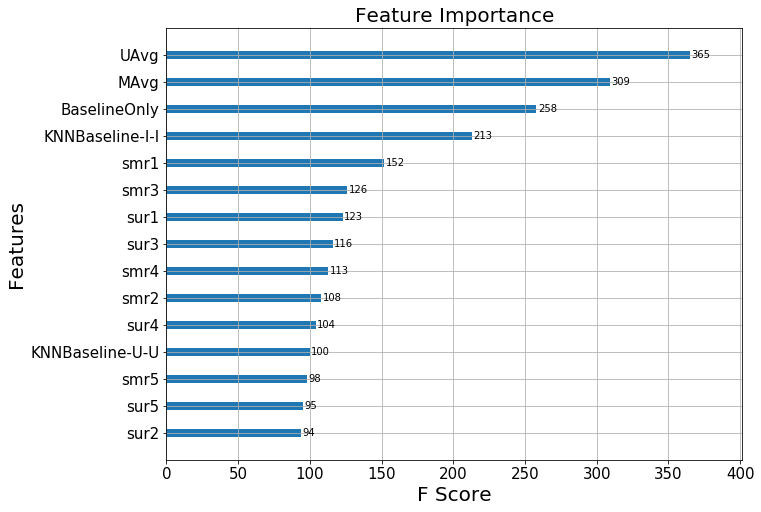

CPU times: user 4.86 s, sys: 320 ms, total: 5.18 s
Wall time: 4.72 s


In [252]:
%%time
train_result, test_result, model_summ_local=test_performance_xgb(train, y_train, test, y_test,\
                                                                 params_, model_summary, model_name[5], summary=True)

#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[5]] = train_result
models_evaluation_test[model_name[5]] = test_result

#### [6.4]Model Summary

In [253]:
#MODEL SUMMARY
print(model_summ_local)

+-------------+-------------+-------------+------------+------------+
|    Model    | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+-------------+-------------+-------------+------------+------------+
| XGBOOST-KNN |   0.82392   |   24.12600  |  1.06919   |  34.61556  |
+-------------+-------------+-------------+------------+------------+


# ============================================================

## 7.SVD:
Predicted Rating:
- $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
- $\pmb q_i$ - Representation of item(movie) in latent factor space
        
- $\pmb p_u$ - Representation of user in new latent factor space

Optimization problem:
- $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

#### [a.] Hyperparam tunning:

In [260]:
%%time
print('HYPERPARAMETER:')
param_list(params, param_summ)
print()
#HYPERPARAM TUNNING
clf=SVD
model = hyperparamTUNNING(clf, data, params_svd, CV_, 'svd', searchMethod[1])

HYPERPARAMETER:
+-------------+-----------------------------------------------------------------------------------------+
|  Parameter  |                                          Value                                          |
+-------------+-----------------------------------------------------------------------------------------+
|      k      |                                     [20, 30, 40, 60]                                    |
| bsl_options |   {'method': ['sgd'], 'n_epochs': [10, 20], 'learning_rate': [0.001, 0.01, 0.05, 0.1]}  |
| sim_options | {'user_based': [False], 'shrinkage': [80, 100, 120, 140], 'name': ['pearson_baseline']} |
|    min_k    |                                           [1]                                           |
+-------------+-----------------------------------------------------------------------------------------+

Train RMSE: 0.9336 CV RMSE: 0.9719
Train RMSE: 0.9372 CV RMSE: 0.9707
Train RMSE: 0.9386 CV RMSE: 0.9710
Train RMSE: 0.9392 CV RMSE: 0.

#### [b.] Performance on test data and summary:

In [261]:
%%time
#INITIALIZE CLASSIFIER WITH BEST PARAMS VALUE
clf=SVD(n_factors=model.best_params['rmse']['n_factors'],\
        n_epochs=model.best_params['rmse']['n_epochs'],\
        lr_all=model.best_params['rmse']['lr_all'],\
        reg_all=model.best_params['rmse']['reg_all'])

#MEASURE PERFORMANCE ON TEST DATA
train_result, test_result, model_summ_local=testPerformance(clf, trainset, testset, train_reg, test_reg, model_name[6], \
                                                            model_summary=model_summary, add_to_xgboost=True)

#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[6]] = train_result
models_evaluation_test[model_name[6]] = test_result

#PRINT PERFROMANCE SUMMARY 
print(model_summ_local)

Performance Summary (WITH OPTIMAL VALUE OF PARAMETERS):
+-------+-------------+-------------+------------+------------+
| Model | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+-------+-------------+-------------+------------+------------+
|  SVD  |   0.84508   |   25.80980  |  1.07418   |  35.13581  |
+-------+-------------+-------------+------------+------------+
CPU times: user 2.76 s, sys: 4 ms, total: 2.76 s
Wall time: 2.76 s


# ============================================================

## 8.SVDpp:
Predicted Rating:
- $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 
- $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  

Optimization Problem:
- $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

#### [a.] Hyperparam tunning:

In [263]:
%%time
print('HYPERPARAMETER:')
param_list(params, param_summ)
print()
#HYPERPARAM TUNNING
clf=SVDpp
model = hyperparamTUNNING(clf, data, params_svd, CV_, 'svd', searchMethod[0])

HYPERPARAMETER:
+-------------+-----------------------------------------------------------------------------------------+
|  Parameter  |                                          Value                                          |
+-------------+-----------------------------------------------------------------------------------------+
|      k      |                                     [20, 30, 40, 60]                                    |
| bsl_options |   {'method': ['sgd'], 'n_epochs': [10, 20], 'learning_rate': [0.001, 0.01, 0.05, 0.1]}  |
| sim_options | {'user_based': [False], 'shrinkage': [80, 100, 120, 140], 'name': ['pearson_baseline']} |
|    min_k    |                                           [1]                                           |
+-------------+-----------------------------------------------------------------------------------------+

Train RMSE: 0.4572 CV RMSE: 1.0431
Train RMSE: 0.2714 CV RMSE: 0.9722
Train RMSE: 0.6510 CV RMSE: 1.0004
Train RMSE: 0.5286 CV RMSE: 0.

#### [b.] Performance on test data and summary:

In [264]:
%%time
#INITIALIZE CLASSIFIER WITH BEST PARAMS VALUE
clf=SVDpp(n_factors=model.best_params['rmse']['n_factors'],\
        n_epochs=model.best_params['rmse']['n_epochs'],\
        lr_all=model.best_params['rmse']['lr_all'],\
        reg_all=model.best_params['rmse']['reg_all'])

#MEASURE PERFORMANCE ON TEST DATA
train_result, test_result, model_summ_local=testPerformance(clf, trainset, testset, train_reg, test_reg, model_name[7], \
                                                            model_summary=model_summary, add_to_xgboost=True)

#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[7]] = train_result
models_evaluation_test[model_name[7]] = test_result

#PRINT PERFROMANCE SUMMARY 
print(model_summ_local)

Performance Summary (WITH OPTIMAL VALUE OF PARAMETERS):
+-------+-------------+-------------+------------+------------+
| Model | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+-------+-------------+-------------+------------+------------+
| SVD++ |   0.67078   |   19.84641  |  1.07450   |  35.11816  |
+-------+-------------+-------------+------------+------------+
CPU times: user 38.5 s, sys: 8 ms, total: 38.6 s
Wall time: 38.6 s


# ============================================================

## 9. XGBOOST( 13 + BSL + KNN + MF[SVD+SVDpp] ):

#### [9.1.] Hyperparameter Tunning:

In [265]:
%%time
#TRAIN AND TEST DATA FOR XGBOOST MODELS
train, test = train_reg.drop(["user", "movie", "rating"], axis = 1), test_reg.drop(["user", "movie", "rating"], axis = 1)
y_train, y_test = train_reg["rating"], test_reg["rating"]
print('HYPERPARAMETER:\n')
param_list(params_range, param_summ)
print()
model, params_ = tuneALL_PARAM_XGB(train, y_train, CV, params_range, params_, searchMethod[1])

HYPERPARAMETER:

+------------------+-------------------------------+
|    Parameter     |             Value             |
+------------------+-------------------------------+
|   n_estimators   |       [32, 64, 80, 100]       |
|    max_depth     |           [5, 7, 9]           |
| min_child_weight |           [1, 3, 5]           |
|      gamma       |   [0.0, 0.1, 0.2, 0.3, 0.4]   |
|    subsample     |      [0.6, 0.7, 0.8, 0.9]     |
| colsample_bytree |      [0.6, 0.7, 0.8, 0.9]     |
|    reg_alpha     | [0, 0.001, 0.005, 0.01, 0.05] |
+------------------+-------------------------------+

Tunning N_ESTIMATORS:
Train RMSE: 0.8430 CV RMSE: 0.8622
Train RMSE: 0.8236 CV RMSE: 0.8497
Train RMSE: 0.8194 CV RMSE: 0.8500
Train RMSE: 0.8148 CV RMSE: 0.8501

Tunning MAX_DEPTH:
Train RMSE: 0.8236 CV RMSE: 0.8497
Train RMSE: 0.7857 CV RMSE: 0.8529
Train RMSE: 0.7179 CV RMSE: 0.8581

Tunning MIN_CHILD_WEIGHT:
Train RMSE: 0.8232 CV RMSE: 0.8495
Train RMSE: 0.8233 CV RMSE: 0.8500
Train RMSE: 0.8

#### [9.2]Optimal value of parameters after tunning:

In [266]:
print('Optimal Value of Hyperparameters after Tunning:\n')
param_list(params_,param_summ)


Optimal Value of Hyperparameters after Tunning:

+------------------+-------+
|    Parameter     | Value |
+------------------+-------+
|   n_estimators   |   64  |
|    max_depth     |   5   |
| min_child_weight |   1   |
|      gamma       |  0.1  |
|    subsample     |  0.8  |
| colsample_bytree |  0.6  |
|    reg_alpha     |  0.01 |
+------------------+-------+


#### [9.3]Test performance :

FOR OPTIMAL PARAMETERS, TRAIN RMSE: 0.82766,  TEST RMSE: 1.06981


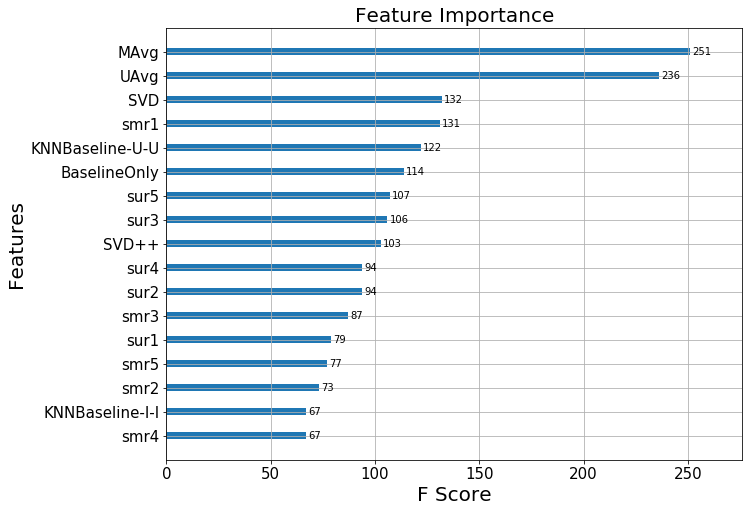

CPU times: user 4.58 s, sys: 332 ms, total: 4.92 s
Wall time: 4.46 s


In [269]:
%%time
train_result, test_result, model_local_summ=test_performance_xgb(train, y_train, test, y_test,\
                                                                 params_, model_summary, model_name[8], summary=True)

#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[8]] = train_result
models_evaluation_test[model_name[8]] = test_result


#### [9.4] model summary:

In [270]:
#MODEL SUMMARY
print(model_summ_local)

+-------+-------------+-------------+------------+------------+
| Model | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+-------+-------------+-------------+------------+------------+
| SVD++ |   0.67078   |   19.84641  |  1.07450   |  35.11816  |
+-------+-------------+-------------+------------+------------+


# ============================================================

## 10. XGBOOST( BSL + KNN + MF[SVD+SVDpp] ):

#### [10.1] Hyperparameter Tunning:

In [274]:
%%time
#SELECT COLUMNS
cols=list(train_reg.columns)
del cols[0:16]

#TRAIN AND TEST DATA FOR XGBOOST MODELS
train, test = train_reg[cols], test_reg[cols]
y_train, y_test = train_reg['rating'], test_reg['rating']

print('HYPERPARAMETER:\n')
param_list(params_range, param_summ)
print()
#HYPERPARAM TUNNING
model, params_ = tuneALL_PARAM_XGB(train, y_train, CV, params_range, params_, searchMethod[0])

HYPERPARAMETER:

+------------------+-------------------------------+
|    Parameter     |             Value             |
+------------------+-------------------------------+
|   n_estimators   |       [32, 64, 80, 100]       |
|    max_depth     |           [5, 7, 9]           |
| min_child_weight |           [1, 3, 5]           |
|      gamma       |   [0.0, 0.1, 0.2, 0.3, 0.4]   |
|    subsample     |      [0.6, 0.7, 0.8, 0.9]     |
| colsample_bytree |      [0.6, 0.7, 0.8, 0.9]     |
|    reg_alpha     | [0, 0.001, 0.005, 0.01, 0.05] |
+------------------+-------------------------------+

Tunning N_ESTIMATORS:
Train RMSE: 1.0447 CV RMSE: 1.0695
Train RMSE: 1.0571 CV RMSE: 1.0739
Train RMSE: 1.0415 CV RMSE: 1.0698

Tunning MAX_DEPTH:
Train RMSE: 1.0447 CV RMSE: 1.0695
Train RMSE: 1.0292 CV RMSE: 1.0710
Train RMSE: 1.0060 CV RMSE: 1.0727

Tunning MIN_CHILD_WEIGHT:
Train RMSE: 1.0439 CV RMSE: 1.0701
Train RMSE: 1.0442 CV RMSE: 1.0699
Train RMSE: 1.0447 CV RMSE: 1.0695

Tunning GAMMA:

#### [10.2]Optimal value of parameters after tunning:

In [276]:
print('Optimal Value of Hyperparameters after Tunning:\n')
param_list(params_,param_summ)


Optimal Value of Hyperparameters after Tunning:

+------------------+-------+
|    Parameter     | Value |
+------------------+-------+
|   n_estimators   |   64  |
|    max_depth     |   5   |
| min_child_weight |   5   |
|      gamma       |  0.3  |
|    subsample     |  0.9  |
| colsample_bytree |  0.9  |
|    reg_alpha     | 0.005 |
+------------------+-------+


#### [10.3]Test performance :

FOR OPTIMAL PARAMETERS, TRAIN RMSE: 1.04781,  TEST RMSE: 1.07510


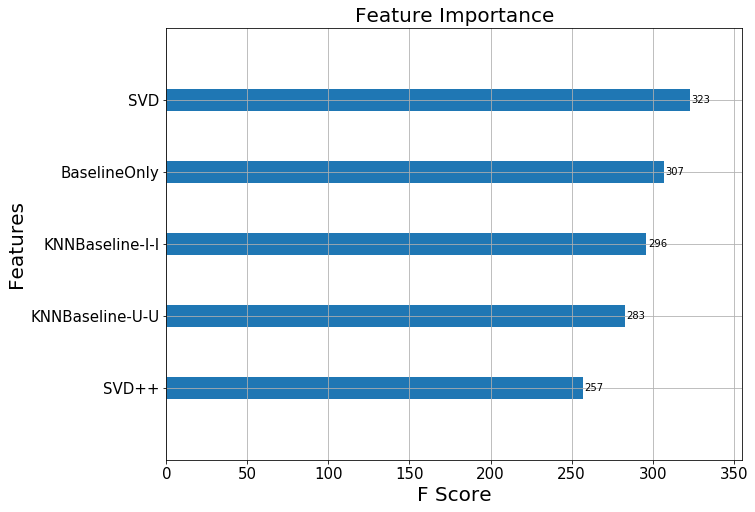

CPU times: user 3.42 s, sys: 996 ms, total: 4.42 s
Wall time: 3.03 s


In [277]:
%%time
train_result, test_result, model_local_summ=test_performance_xgb(train, y_train, test, y_test,\
                                                                 params_, model_summary, model_name[9], summary=True)

#SAVE THE TEST RESULTS TO DICT OF DICT
models_evaluation_train[model_name[9]] = train_result
models_evaluation_test[model_name[9]] = test_result


#### [10.4] Model Summary:

In [280]:
#MODEL SUMMARY
print(model_local_summ)

+--------------------+-------------+-------------+------------+------------+
|       Model        | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+--------------------+-------------+-------------+------------+------------+
| XGBOOST-BSL-KNN-MF |   1.04781   |   33.96307  |  1.07510   |  35.23055  |
+--------------------+-------------+-------------+------------+------------+


# ============================================================

## Conclusion:

In [281]:
print(model_summary)

+-----------------------+-------------+-------------+------------+------------+
|         Model         | Train(RMSE) | Train(MAPE) | Test(RMSE) | Test(MAPE) |
+-----------------------+-------------+-------------+------------+------------+
|    XGBOOST-13-FEATS   |   0.82606   |   24.16566  |  1.07701   |  33.59137  |
|      BaselineOnly     |   0.83552   |   25.25685  |  1.07429   |  35.12019  |
|      XGBOOST-BSL      |   0.82509   |   24.14721  |  1.06767   |  34.57024  |
|    KNNBaseline-U-U    |   0.14034   |   3.41399   |  1.07426   |  35.11784  |
|    KNNBaseline-I-I    |   0.27398   |   6.45966   |  1.07461   |  35.19819  |
|      XGBOOST-KNN      |   0.82392   |   24.12600  |  1.06919   |  34.61556  |
|          SVD          |   0.84508   |   25.80980  |  1.07418   |  35.13581  |
|         SVD++         |   0.67078   |   19.84641  |  1.07450   |  35.11816  |
| XGBOOST-13-BSL-KNN-MF |   0.82766   |   24.27682  |  1.06981   |  34.19354  |
|   XGBOOST-BSL-KNN-MF  |   1.04781   | 

## Best performance given by model:
        1. XGBOOST+BSL with RMSE=1.06767
        2. XGBOOST+KNN with RMSE=1.06919

## Procedure:
1. We have to solve a problem, where we have to predict a rating given by user to movie not yet watched by that user.
2. We can map this problem to Machine Learning problem in 2 ways:
        a. Recommendation system.
        b. Regression problem.
3. We proceed with loading the dataset and with basic details of the dataset:
        a. How many users are present in dataset?
        b. How many movies are present in dataset?
        c. How many ratings are present?
4. As the time stamps are given in dataset so we sorted the data in ascending order of time and splitted it into train and test data for further analysis(Temporal Fashion). 
5. We did EDA and Feature Extraction:
        a. Ratings:
                ->ratings per movie.
                ->how many movies a user rated?
                ->PDF and CDF of ratings given by a user.
        b. Build movie-movie similarity matrix.
        c. As we have huge amount of data we build sample train data for train data and sample test data from test data .
        d. We feturize sample train data and sample test data for regression:
                ->global avg, user avg and movie avg.
                ->sur = top 5 similar users rating for a movie.
                ->smr = top 5 similar movies rating by a user.
                ->handled cold start problem(new user / new movie) by taking global average.
6. We convert data so that accepted by surprise library. 
7. We Build ML models:
        a. Regression(XGBOOST) model.
        b. Surprise library models:
                ->BaselineOnly 
                ->KNNBasseline
                ->SVD 
                ->SVDpp
#### Note: 
#### -After applying each of the surprise library model we add output of that model as a new feature to our regression data and build regression model on that data. 
#### -Ways to handle cold start problem:
        1. Recommend globally top movies initially to a new user.
        2. From ip address we can find information like user belongs to which region, and based on that region we recommend movies which are popular in that region to a new user.
        3. Recommend movies/items based on the few of the items/movies watched by the user.